# Predicting beer style with a neural network model

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import dump
import category_encoders as ce

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

### Section 1: Data exploration from BeerAdvocates

We import data from BeerAdvocates.com

In [98]:
df = pd.read_csv("../data/raw/beer_reviews.csv")

There are 1.6 million reviews and 13 columns

In [99]:
df.shape

(1586614, 13)

In [100]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


The expected API parameter brewery name has 15 null values. 
The expected API parameter beer_abv (alcohol level) has ~70000 nulls

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [102]:
df.describe(include='all')

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
count,1.586614e+06,1586599,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1586266,1586614,1.586614e+06,1.586614e+06,1586614,1.518829e+06,1.586614e+06
unique,NaN,5742,NaN,NaN,NaN,NaN,33387,104,NaN,NaN,56857,NaN,NaN
top,NaN,Boston Beer Company (Samuel Adams),NaN,NaN,NaN,NaN,northyorksammy,American IPA,NaN,NaN,90 Minute IPA,NaN,NaN
freq,NaN,39444,NaN,NaN,NaN,NaN,5817,117586,NaN,NaN,3290,NaN,NaN
mean,3.130099e+03,NaN,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,NaN,NaN,3.743701e+00,3.792860e+00,NaN,7.042387e+00,2.171279e+04
std,5.578104e+03,NaN,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,NaN,NaN,6.822184e-01,7.319696e-01,NaN,2.322526e+00,2.181834e+04
min,1.000000e+00,NaN,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,NaN,NaN,1.000000e+00,1.000000e+00,NaN,1.000000e-02,3.000000e+00
25%,1.430000e+02,NaN,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,NaN,NaN,3.500000e+00,3.500000e+00,NaN,5.200000e+00,1.717000e+03
50%,4.290000e+02,NaN,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,NaN,NaN,4.000000e+00,4.000000e+00,NaN,6.500000e+00,1.390600e+04
75%,2.372000e+03,NaN,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,NaN,NaN,4.000000e+00,4.500000e+00,NaN,8.500000e+00,3.944100e+04


There are 104 styles of beer. The most common type of beer is 7% of the total.
There are 5742 breweries. This could be why there's lots of different styles as the breweries have their specialties.

In [103]:
beer_name = df['beer_style'].str.strip()
beer_name.value_counts(normalize=True) * 100

American IPA                        7.411128
American Double / Imperial IPA      5.418898
American Pale Ale (APA)             4.000280
Russian Imperial Stout              3.411605
American Double / Imperial Stout    3.195799
                                      ...   
Gose                                0.043237
Faro                                0.038384
Roggenbier                          0.029371
Kvass                               0.018719
Happoshu                            0.015190
Name: beer_style, Length: 104, dtype: float64

<b> The top 10 beer style </b>

The most common beer style in the dataset are American-style beers

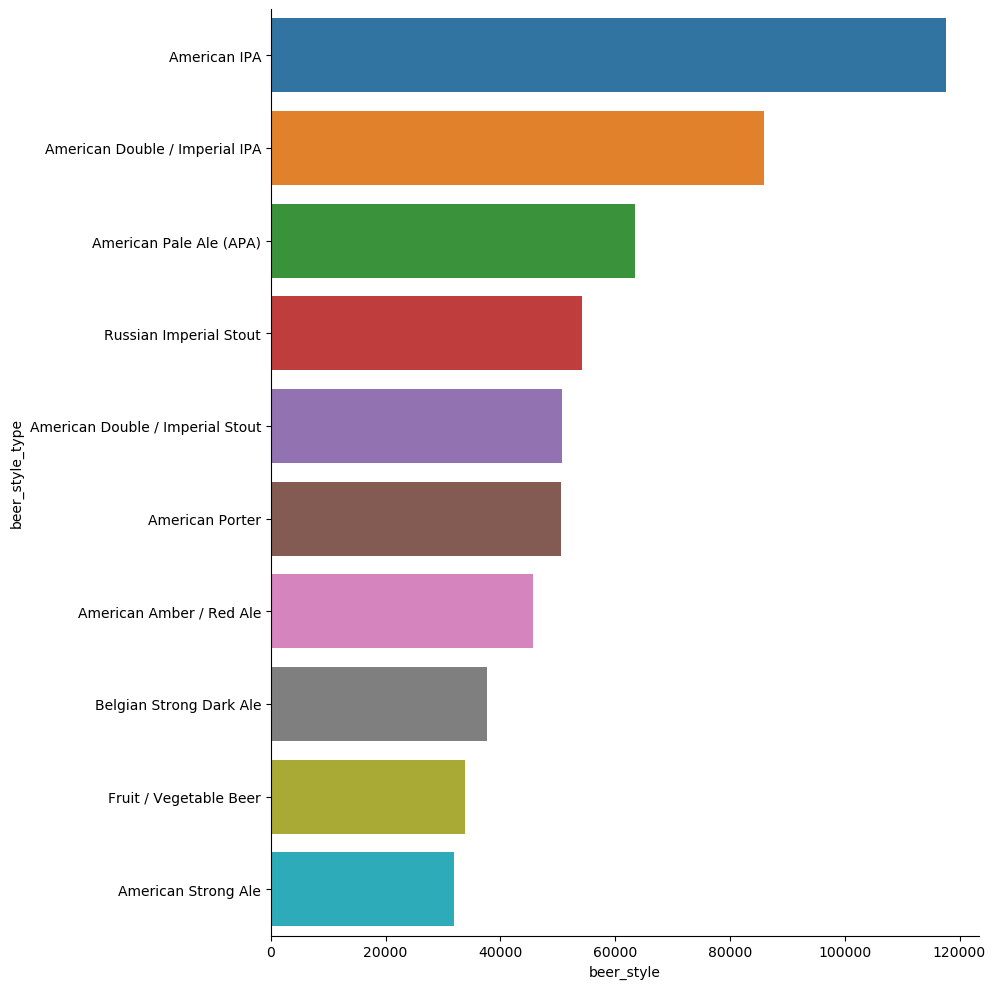

In [104]:
chart_data = pd.DataFrame(beer_name.value_counts())
chart_data['beer_style_type'] = chart_data.index
chart_data
sns.catplot(y='beer_style_type', x='beer_style', data=chart_data[:10], height=10, kind="bar")

### Section 2: Dealing with null values

There were null values for brewery names

In [105]:
len(df[df['brewery_name'].isnull()])

15

As there's only 15 with null values, we will drop these rows

In [106]:
df_clean = df.copy()
df_clean = df_clean.dropna(subset=['brewery_name'])

In [107]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586599 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586599 non-null int64
brewery_name          1586599 non-null object
review_time           1586599 non-null int64
review_overall        1586599 non-null float64
review_aroma          1586599 non-null float64
review_appearance     1586599 non-null float64
review_profilename    1586251 non-null object
beer_style            1586599 non-null object
review_palate         1586599 non-null float64
review_taste          1586599 non-null float64
beer_name             1586599 non-null object
beer_abv              1518814 non-null float64
beer_beerid           1586599 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 169.5+ MB


In [108]:
#Reset the index
df_clean.reset_index(drop=True, inplace=True)

In [109]:
df_clean.describe(include="all")

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
count,1.586599e+06,1586599,1.586599e+06,1.586599e+06,1.586599e+06,1.586599e+06,1586251,1586599,1.586599e+06,1.586599e+06,1586599,1.518814e+06,1.586599e+06
unique,NaN,5742,NaN,NaN,NaN,NaN,33387,104,NaN,NaN,56848,NaN,NaN
top,NaN,Boston Beer Company (Samuel Adams),NaN,NaN,NaN,NaN,northyorksammy,American IPA,NaN,NaN,90 Minute IPA,NaN,NaN
freq,NaN,39444,NaN,NaN,NaN,NaN,5817,117584,NaN,NaN,3290,NaN,NaN
mean,3.130122e+03,NaN,1.224089e+09,3.815584e+00,3.735638e+00,3.841647e+00,NaN,NaN,3.743705e+00,3.792864e+00,NaN,7.042396e+00,2.171249e+04
std,5.578125e+03,NaN,7.654410e+07,7.206191e-01,6.976142e-01,6.160899e-01,NaN,NaN,6.822131e-01,7.319658e-01,NaN,2.322532e+00,2.181807e+04
min,1.000000e+00,NaN,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,NaN,NaN,1.000000e+00,1.000000e+00,NaN,1.000000e-02,3.000000e+00
25%,1.430000e+02,NaN,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,NaN,NaN,3.500000e+00,3.500000e+00,NaN,5.200000e+00,1.717000e+03
50%,4.290000e+02,NaN,1.239202e+09,4.000000e+00,4.000000e+00,4.000000e+00,NaN,NaN,4.000000e+00,4.000000e+00,NaN,6.500000e+00,1.390600e+04
75%,2.372000e+03,NaN,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,NaN,NaN,4.000000e+00,4.500000e+00,NaN,8.500000e+00,3.944100e+04


There were ~70000 null alcohol level values.
We will estimate these null values by using the average alcohol level for the beer style

In [110]:
#Replace na alcohol levels by the average alcohol level for the beer style
df_clean["beer_abv"]=df_clean.groupby("beer_style")["beer_abv"].transform(lambda x: x.fillna(x.mean()))

In [111]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586599 entries, 0 to 1586598
Data columns (total 13 columns):
brewery_id            1586599 non-null int64
brewery_name          1586599 non-null object
review_time           1586599 non-null int64
review_overall        1586599 non-null float64
review_aroma          1586599 non-null float64
review_appearance     1586599 non-null float64
review_profilename    1586251 non-null object
beer_style            1586599 non-null object
review_palate         1586599 non-null float64
review_taste          1586599 non-null float64
beer_name             1586599 non-null object
beer_abv              1586599 non-null float64
beer_beerid           1586599 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


Now there is no more null values for the API parameter fields.
The overall alcohol level stats remain unchanged

In [112]:
#overall stats unchanged
df_clean.describe(include="all")

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
count,1.586599e+06,1586599,1.586599e+06,1.586599e+06,1.586599e+06,1.586599e+06,1586251,1586599,1.586599e+06,1.586599e+06,1586599,1.586599e+06,1.586599e+06
unique,NaN,5742,NaN,NaN,NaN,NaN,33387,104,NaN,NaN,56848,NaN,NaN
top,NaN,Boston Beer Company (Samuel Adams),NaN,NaN,NaN,NaN,northyorksammy,American IPA,NaN,NaN,90 Minute IPA,NaN,NaN
freq,NaN,39444,NaN,NaN,NaN,NaN,5817,117584,NaN,NaN,3290,NaN,NaN
mean,3.130122e+03,NaN,1.224089e+09,3.815584e+00,3.735638e+00,3.841647e+00,NaN,NaN,3.743705e+00,3.792864e+00,NaN,7.001863e+00,2.171249e+04
std,5.578125e+03,NaN,7.654410e+07,7.206191e-01,6.976142e-01,6.160899e-01,NaN,NaN,6.822131e-01,7.319658e-01,NaN,2.297941e+00,2.181807e+04
min,1.000000e+00,NaN,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,NaN,NaN,1.000000e+00,1.000000e+00,NaN,1.000000e-02,3.000000e+00
25%,1.430000e+02,NaN,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,NaN,NaN,3.500000e+00,3.500000e+00,NaN,5.200000e+00,1.717000e+03
50%,4.290000e+02,NaN,1.239202e+09,4.000000e+00,4.000000e+00,4.000000e+00,NaN,NaN,4.000000e+00,4.000000e+00,NaN,6.500000e+00,1.390600e+04
75%,2.372000e+03,NaN,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,NaN,NaN,4.000000e+00,4.500000e+00,NaN,8.500000e+00,3.944100e+04


### Section 3. Create the target variables and feature engineering the brewery ids

The target variable - beer style- will be converted to an array of integers

In [113]:
#pop target into another y list
target = df_clean['beer_style']

In [114]:
target.head()

0                        Hefeweizen
1                English Strong Ale
2            Foreign / Export Stout
3                   German Pilsener
4    American Double / Imperial IPA
Name: beer_style, dtype: object

We fit target to a label encoder

In [115]:
le = LabelEncoder()

In [116]:
fitted_target = le.fit_transform(target)

In [117]:
fitted_target

array([65, 51, 59, ..., 85, 85, 85])

In [118]:
#Dump the label encoder into the models folder
dump(le,  '../models/le.joblib')

['../models/le.joblib']

<b> Feature engineering the brewery ids </b>

There are 5742 breweries in the data set.

We were unable to one-hot encode the brewery id due to its high cardinality.

We will now look at its distribution to see if we can group them into smaller groups.

In [119]:
brewery_id = df_clean['brewery_id']
chart_data_2 = pd.DataFrame(brewery_id.value_counts())
chart_data_2.describe()

,brewery_id
count,5838.000000
mean,271.770983
std,1488.121955
min,1.000000
25%,3.000000
50%,14.000000
75%,71.000000
max,39444.000000


A lot of breweries have a small amount of reviews. This could lead to overfitting if they try to model the reviews for these breweries

There 5838 brewery ids vs 5742 brewery names, meaning there are some breweries with the same name (but potentially different location. Location is not in the dataset.

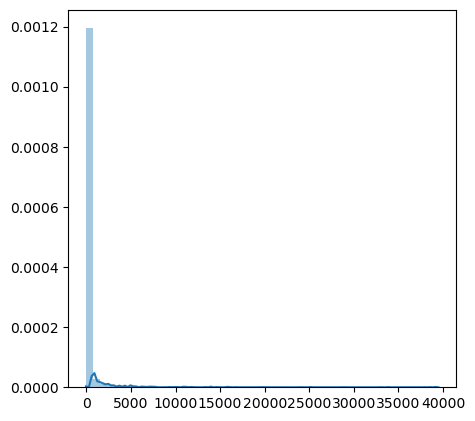

In [122]:
sns.distplot(chart_data_2)

Only 1209 out of the 5838 brewery ids have more than 100 reviews

In [27]:
len(chart_data_2[chart_data_2['brewery_id']>100])

1209

Even if group brewery ids with less than 100 are grouped as 'Other', still too much classes for one-hot encoding.

Will have to convert the brewery id into a numerical feature. We will use target encoding.

But first, we will create a new brewery id feature

In [123]:
#Create a brewery id feature where if less than 100 reviews, the id is '0'

In [124]:
brewery_id_new = pd.DataFrame(df_clean['brewery_id'])

brewery_id_new['brewery_id_count']=brewery_id_new.groupby('brewery_id')['brewery_id'].transform('count')
brewery_id_new['id_new'] = brewery_id_new['brewery_id_count'].transform(lambda x: x if x > 100 else 0)
brewery_id_new['id_new'] = brewery_id_new.loc[brewery_id_new['id_new'] > 100, 'brewery_id'].fillna(0)


brewery_id_new.fillna(0, inplace=True)
brewery_id_new

,brewery_id,brewery_id_count,id_new
0,10325,4,0.0
1,10325,4,0.0
2,10325,4,0.0
3,10325,4,0.0
4,1075,889,1075.0
...,...,...,...
1586594,14359,279,14359.0
1586595,14359,279,14359.0
1586596,14359,279,14359.0
1586597,14359,279,14359.0


Now we will target encode the id_bew column. To prevent overfitting groups with small sample sizes, we will use a minimum sample size of 270 per batch. A smoothing co-efficient of 0.5 applied to still incorporate average for groups that had sufficient sample

In [125]:
ce_target = ce.TargetEncoder(cols = ['id_new'], min_samples_leaf=270, smoothing = 0.5) 

In [126]:
X=pd.DataFrame(brewery_id_new['id_new'])

In [127]:
Y=pd.DataFrame(fitted_target)

In [128]:
ce_target.fit(X,Y)

TargetEncoder(cols=['id_new'], drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=270, return_df=True,
              smoothing=0.5, verbose=0)

Now the brewery id has been converted to a numerical feature

In [129]:
encoded_brewery_id=ce_target.transform(X,Y)
encoded_brewery_id

,id_new
0,40.871617
1,40.871617
2,40.871617
3,40.871617
4,18.587177
...,...
1586594,43.293907
1586595,43.293907
1586596,43.293907
1586597,43.293907


There are 702 unique values in the brewery id after target encoding

In [131]:
len(encoded_brewery_id.drop_duplicates())

702

In [132]:
#dump the category encoder into the models folder
dump(ce_target,  '../models/ce_target.joblib')

['../models/ce_target.joblib']

Add the target encoded brewery id into the dataframe.

In [133]:
df_clean['encoded_brewery_id'] = encoded_brewery_id

### Section 4. Creating training, testing, and validation datasets

We create the create a matrix of the features to be used in the model

In [135]:
num_cols=['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv', 'encoded_brewery_id']

In [136]:
#Create matrix of X variables
X_analysis = df_clean[num_cols]
X_analysis

,review_aroma,review_appearance,review_palate,review_taste,beer_abv,encoded_brewery_id
0,2.0,2.5,1.5,1.5,5.0,40.871617
1,2.5,3.0,3.0,3.0,6.2,40.871617
2,2.5,3.0,3.0,3.0,6.5,40.871617
3,3.0,3.5,2.5,3.0,5.0,40.871617
4,4.5,4.0,4.0,4.5,7.7,18.587177
...,...,...,...,...,...,...
1586594,4.0,3.5,4.0,4.0,5.2,43.293907
1586595,5.0,2.5,2.0,4.0,5.2,43.293907
1586596,3.5,3.0,3.5,4.0,5.2,43.293907
1586597,4.5,4.5,4.5,4.5,5.2,43.293907


In [137]:
#All the features are now numerical. Scale the features.
sc = StandardScaler()
X_analysis=  sc.fit_transform(X_analysis)
X_analysis

array([[-2.48796366, -2.17768163, -3.28886329, -3.13247601, -0.87115549,
        -0.09139965],
       [-1.77123494, -1.36611144, -1.09013615, -1.0831992 , -0.34894872,
        -0.09139965],
       [-1.77123494, -1.36611144, -1.09013615, -1.0831992 , -0.21839702,
        -0.09139965],
       ...,
       [-0.33777748, -1.36611144, -0.3572271 ,  0.28298534, -0.78412103,
         0.07323325],
       [ 1.09567997,  1.06859912,  1.108591  ,  0.96607761, -0.78412103,
         0.07323325],
       [ 1.09567997,  1.06859912,  1.108591  ,  0.96607761, -0.78412103,
         0.07323325]])

In [138]:
#dump the scaler into the models folder
dump(sc,  '../models/sc.joblib')

['../models/sc.joblib']

In [139]:
#Split model into train, validation, and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_analysis, fitted_target, test_size=0.2, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=8) 

### Section 5. Fit a neural network model using PyTorch

We will convert our dataset into tensors

In [141]:
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

We will fit a model with three hidden layers. Each layer is normalised. The layers are activated with a
non-linear tanh function

In [142]:
class PytorchMultiClass(nn.Module):
    def __init__(self, num_features):
        super(PytorchMultiClass, self).__init__()
        self.layer_1 = nn.Linear(num_features, 512)
        self.norm_1=nn.LayerNorm(512)
        self.layer_2 = nn.Linear(512, 256)
        self.norm_2=nn.LayerNorm(256)
        self.layer_3 = nn.Linear(256, 128)
        self.norm_3=nn.LayerNorm(128)
        self.layer_out = nn.Linear(128, 104)        

    def forward(self, x):
        x = F.tanh(self.layer_1(x))
        x = self.norm_1(x)
        x = F.tanh(self.layer_2(x))
        x = self.norm_2(x)
        x = F.tanh(self.layer_3(x))
        x = self.norm_3(x)
        x = self.layer_out(x)

In [143]:
model = PytorchMultiClass(X_train.shape[1])

In [144]:
from src.models.pytorch import get_device

device = get_device()
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=6, out_features=512, bias=True)
  (norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (norm_3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (layer_out): Linear(in_features=128, out_features=104, bias=True)
)

As it is multi-classification model, a cross entropy loss function is applied

In [145]:
criterion = nn.CrossEntropyLoss()

The loss function is optimised using ADAM optimiser, learning rate = 0.001

In [146]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [140]:
from src.models.pytorch import train_classification
from src.models.pytorch import test_classification

The accuracy level of stabilised at around 67% after 100 epochs

In [66]:
N_EPOCHS = 10
BATCH_SIZE = 1000

In [67]:
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: 0.0011	|	Acc: 67.5%
	(valid)	|	Loss: 0.0012	|	Acc: 66.8%
Epoch: 1
	(train)	|	Loss: 0.0011	|	Acc: 67.5%
	(valid)	|	Loss: 0.0011	|	Acc: 67.0%
Epoch: 2
	(train)	|	Loss: 0.0011	|	Acc: 67.6%
	(valid)	|	Loss: 0.0012	|	Acc: 66.9%
Epoch: 3
	(train)	|	Loss: 0.0011	|	Acc: 67.6%
	(valid)	|	Loss: 0.0011	|	Acc: 67.3%
Epoch: 4
	(train)	|	Loss: 0.0011	|	Acc: 67.6%
	(valid)	|	Loss: 0.0011	|	Acc: 67.3%
Epoch: 5
	(train)	|	Loss: 0.0011	|	Acc: 67.7%
	(valid)	|	Loss: 0.0011	|	Acc: 67.1%
Epoch: 6
	(train)	|	Loss: 0.0011	|	Acc: 67.7%
	(valid)	|	Loss: 0.0011	|	Acc: 66.9%
Epoch: 7
	(train)	|	Loss: 0.0011	|	Acc: 67.7%
	(valid)	|	Loss: 0.0011	|	Acc: 67.2%
Epoch: 8
	(train)	|	Loss: 0.0011	|	Acc: 67.7%
	(valid)	|	Loss: 0.0011	|	Acc: 66.9%
Epoch: 9
	(train)	|	Loss: 0.0011	|	Acc: 67.7%
	(valid)	|	Loss: 0.0011	|	Acc: 67.2%


In [68]:
#torch.save(model.state_dict(), "../models/beeroracle_final_normal.pt")

In [69]:
test_loss, test_acc = test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:.4f}\t|\tAccuracy: {test_acc:.2f}')

	Loss: 0.0011	|	Accuracy: 0.67
